In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style
from TCGA_files import get_tcga_tissue

In [15]:
l = 4
#setup = '5000doc_0.25occ_fpkmweight_thr'
#setup='overlap_5000doc_0.25occ_fpkmweight_thr'
setup = 'oversigma_10tissue'
#label = 'disease_type'
labels = ['primary_site', 'secondary_site']
label=labels[0]
algorithm = "topsbm"
#directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/results/hSBM/%s/"%(setup)
directory='/home/fvalle/phd/results/merged/hsbm'
#directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/gtex/hsbm/oversigma_10tissue"

In [16]:
df = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df.head()

,i_doc,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25
0,0,GTEX-111FC-1026-SM-5GZX1,0.276527,0.223794,0.369775,0.034727,0.024437,0.051447,0.003215,0.000000,...,0.000000,0.0,0.001286,0.001286,0.001929,0.001929,0.0,0.0,0.000000,0.000643
1,1,GTEX-111VG-2226-SM-5N9DU,0.292088,0.198096,0.396788,0.030339,0.025580,0.044616,0.002380,0.000000,...,0.000595,0.0,0.001190,0.001190,0.000000,0.000000,0.0,0.0,0.000595,0.000000
2,2,GTEX-111YS-1626-SM-5GZZ9,0.288560,0.214010,0.376607,0.029563,0.025707,0.052057,0.001928,0.000643,...,0.000000,0.0,0.000643,0.001285,0.000643,0.001928,0.0,0.0,0.000000,0.000000
3,3,GTEX-1122O-0126-SM-5GICA,0.292216,0.229551,0.361478,0.032982,0.017810,0.054090,0.001979,0.000660,...,0.000000,0.0,0.001319,0.000000,0.000660,0.000000,0.0,0.0,0.000000,0.000000
4,4,GTEX-1122O-1926-SM-5EGIQ,0.283374,0.210558,0.385316,0.033374,0.023058,0.048544,0.002427,0.000000,...,0.000607,0.0,0.000607,0.001214,0.001214,0.001214,0.0,0.0,0.000000,0.000000


### Specific topic

In [ ]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, l, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,df,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc, df)

## Topic distr

### kl

In [281]:
l=4

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files['primary_site'].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [286]:
l=4

In [222]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_files = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)['primary_site']))

In [229]:
df_cmap.divide(df_cmap.sum(axis=1),axis=0)

tissue,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,...,uterus,uterus,uterus,uterus,uterus,uterus,uterus,uterus,uterus,uterus
Topic 1,0.000891,0.001274,0.000734,0.001024,0.001067,0.000557,0.000849,0.000723,0.000826,0.000926,...,0.000929,0.000781,0.000902,0.000775,0.001133,0.001245,0.001538,0.000716,0.001174,0.000914
Topic 2,0.001403,0.001283,0.001453,0.001547,0.000940,0.001285,0.001374,0.001561,0.001387,0.001602,...,0.001073,0.000983,0.001136,0.000976,0.000594,0.000784,0.000646,0.001001,0.001023,0.001036
Topic 3,0.001047,0.000958,0.000789,0.000963,0.001003,0.000524,0.001368,0.000971,0.001036,0.001088,...,0.001311,0.000653,0.000679,0.001458,0.000532,0.001003,0.000964,0.001196,0.000849,0.001032
Topic 4,0.000923,0.001055,0.001303,0.000424,0.000442,0.001153,0.001004,0.000855,0.000761,0.000000,...,0.001604,0.001797,0.001868,0.001606,0.002345,0.001473,0.000849,0.001975,0.001496,0.001136
Topic 5,0.001410,0.001075,0.000664,0.001296,0.001351,0.001175,0.000767,0.001307,0.000581,0.000732,...,0.000980,0.001098,0.001142,0.000981,0.001195,0.001125,0.001298,0.001006,0.001143,0.001157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic 227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012270
Topic 228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020172,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.015144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic 229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.006533,0.000000,0.005839,0.000000,0.006695,0.000000,0.000000,0.000000,0.000000
Topic 230,0.000000,0.000000,0.002357,0.000000,0.000000,0.000000,0.002724,0.004642,0.000000,0.000000,...,0.001740,0.001950,0.000000,0.003485,0.004241,0.000000,0.000000,0.001786,0.000000,0.000000


<Figure size 432x288 with 0 Axes>

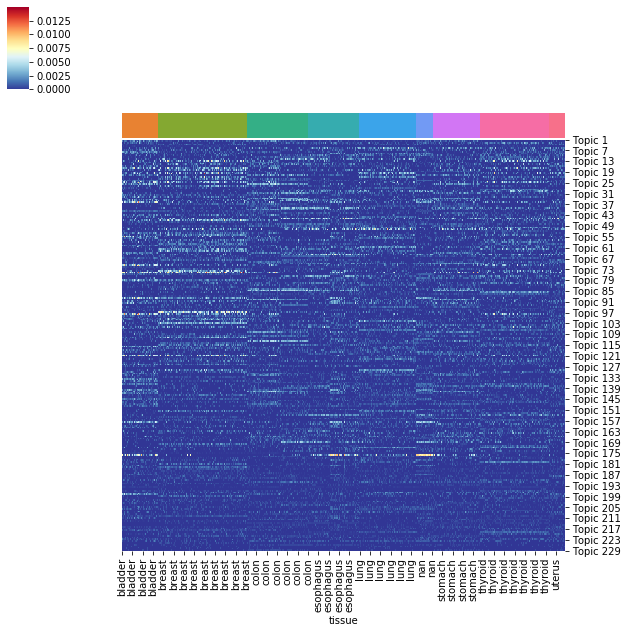

In [232]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', vmin=0, cmap='RdYlBu_r', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [ ]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)['primary_site'])

In [ ]:
fig = plt.figure(figsize=(25,12))
for tissue in df_topics['tissue'].unique():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        df_topics[df_topics['tissue']==tissue].loc[:,df_topics.columns[0:20]].mean(axis=0).plot(ls=ls,marker=marker, lw=2, ms=10, label=tissue, c=network_lut[df_files[df_files['primary_site']==tissue]['primary_site'][0]])
    except:
        pass
plt.xticks(rotation=90, fontsize=24)
plt.ylabel("$P(topic | tissue)$", fontsize=28)
plt.legend(fontsize=18)
plt.show()
fig.savefig("%s/%s/lifeplot.pdf"%(directory,algorithm))

In [ ]:
expressedtopics = df_topics.drop('tissue', axis=1).mean(axis=0).sort_values(ascending=False).index

In [ ]:
fig=plt.figure()
for thr in [0, 0.002, 0.005,0.01]:
    plt.hist(df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>thr])/float(len(x)), axis=1), histtype='step', density=True, range=(-0.05,1.05), bins=10, lw=2, label="threshold: %.3f"%thr)
plt.legend()
fig.savefig("%s/%s/distr_topicU.pdf"%(directory,algorithm))

In [ ]:
topic_table = df_topics.drop('tissue', axis=1).transpose()
topic_table.insert(0,'occ', df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>0.002])/float(len(x)), axis=1).values)

In [ ]:
low_occ_topics = topic_table[topic_table['occ']<0.05].index.values
#low_occ_topics = ["Topic 19", "Topic 153", "Topic 185","Topic 201"]
l_topics_i = [int(t[6:])-1 for t in low_occ_topics]
#l_topics_i = np.random.randint(0,100,10)

In [19]:
import findspark
findspark.init()
import pyspark as spark
import tensorflow as tf
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [287]:
df_files_pd = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics = sql.read.option("header","true").csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_files = sql.read.option("header","true").csv("%s/files.dat"%(directory))
df_files.registerTempTable("file")
df_topics = df_topics.withColumn('status', udf(lambda x: 'healthy' if 'GTEX' in x else 'tumour', StringType())(col('doc')))
df_topics = df_topics.withColumn('tissue', udf(lambda x: get_file(x, df_files_pd)[labels[0]], StringType())(col('doc')))
df_topics = df_topics.withColumn('second_tissue', udf(lambda x: get_file(x, df_files_pd)[labels[1]], StringType())(col('doc')))
df_topics.registerTempTable("topic")

### only health vs disease

In [113]:
dftf_h = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='healthy'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='tumour'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)

In [114]:
with tf.Session() as sess:
    results = sess.run([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)])

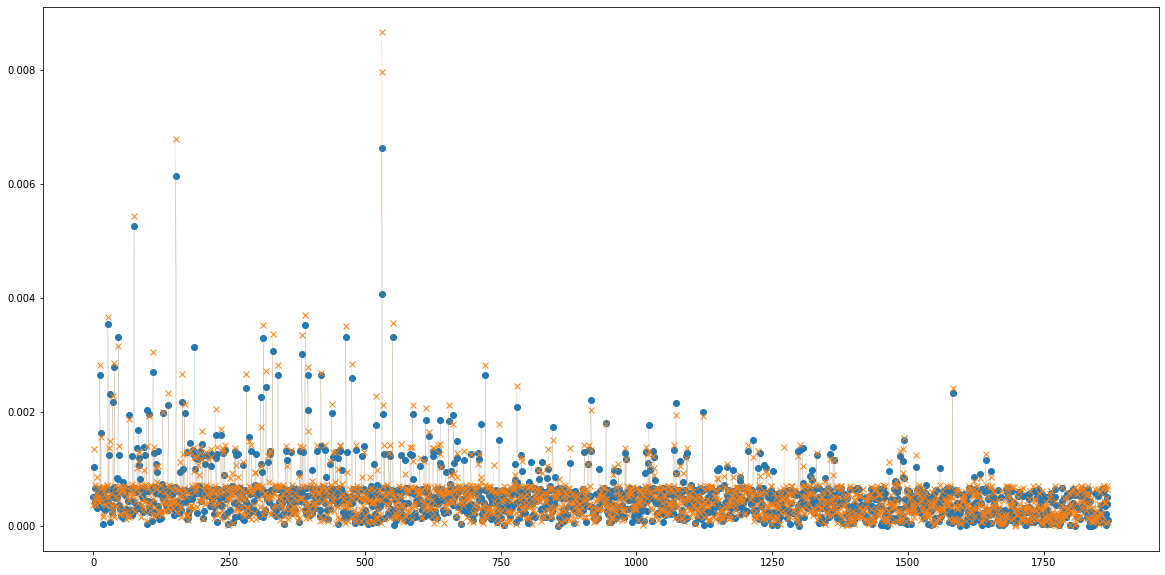

In [115]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0], marker='o', lw=0.1)
plt.plot(results[1],marker='x', lw=0.1)
plt.show()

In [288]:
df_topics.groupby('second_tissue').count().sort('second_tissue').show()

+--------------------+-----+
|       second_tissue|count|
+--------------------+-----+
|        bladder-gtex|    4|
|        bladder-tcga|   70|
|         breast-gtex|   11|
|         breast-tcga|  171|
|          colon-gtex|   55|
|          colon-tcga|    3|
|  colon_sigmoid-tcga|   13|
|colon_trasverse-tcga|   52|
|      esophagus-tcga|   33|
|  esophagus_gas-gtex|   32|
|  esophagus_muc-gtex|   35|
|  esophagus_mus-gtex|   39|
|           lung-gtex|   40|
|           lung-tcga|   76|
|        stomach-gtex|   34|
|        stomach-tcga|   60|
|        thyroid-gtex|   63|
|        thyroid-tcga|   78|
|         uterus-gtex|   12|
|         uterus-tcga|   20|
+--------------------+-----+



In [289]:
topic_cols=df_topics.columns[2:-3]
look_for = ['lung', 'lung-gtex','lung-tcga']
exprs = {x: "avg" for x in topic_cols}
df_tissue_healthy=df_topics.filter(col('second_tissue')==look_for[1]).select(topic_cols).agg(exprs).toPandas()[["avg(%s)"%topic for topic in topic_cols]]
df_tissue_disease=df_topics.filter(col('second_tissue')==look_for[2]).select(topic_cols).agg(exprs).toPandas()[["avg(%s)"%topic for topic in topic_cols]]

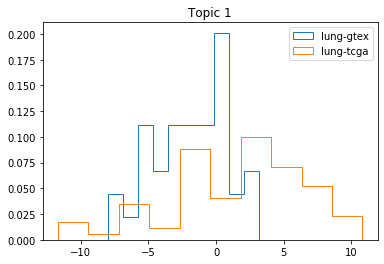

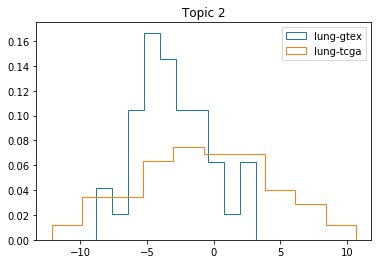

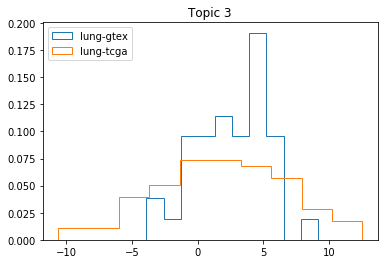

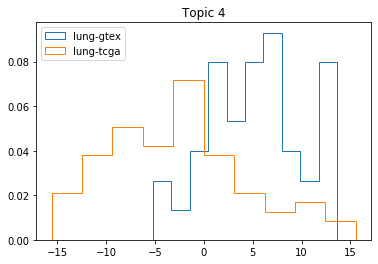

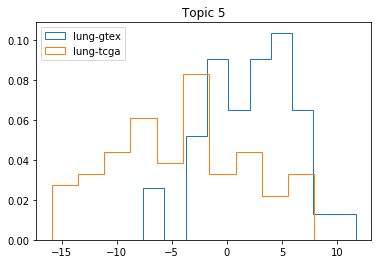

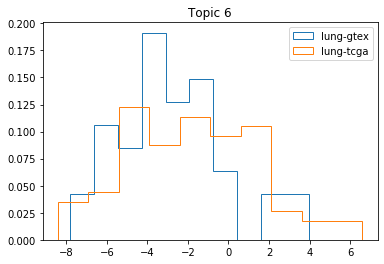

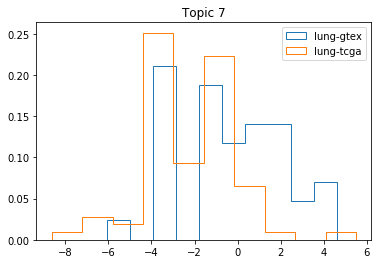

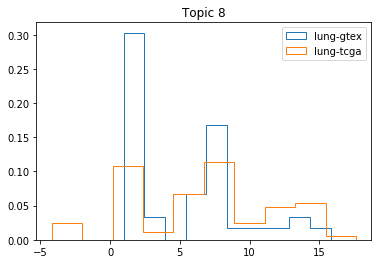

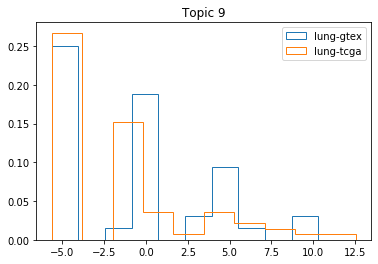

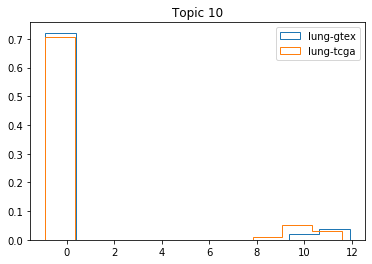

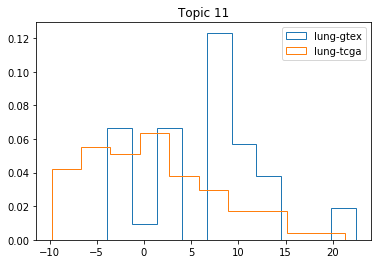

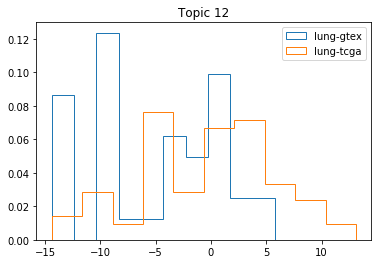

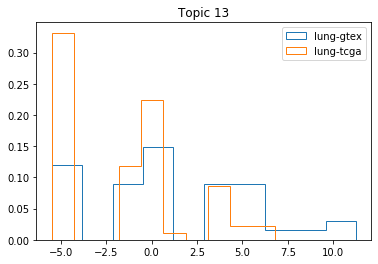

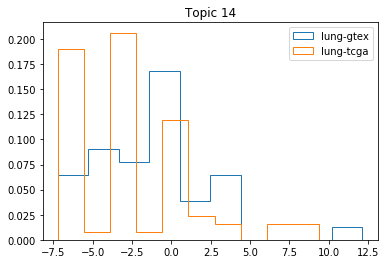

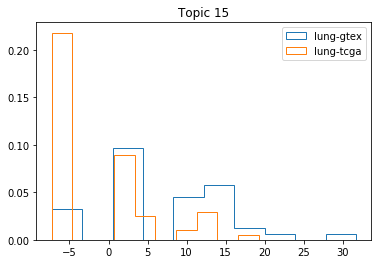

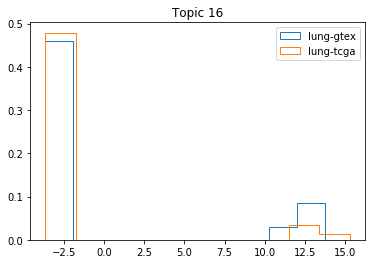

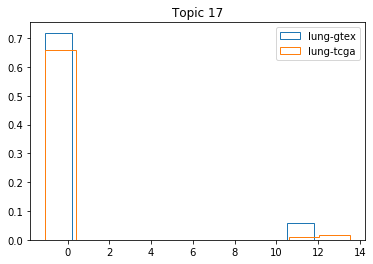

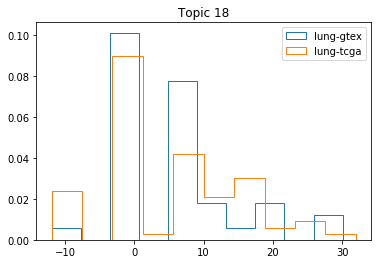

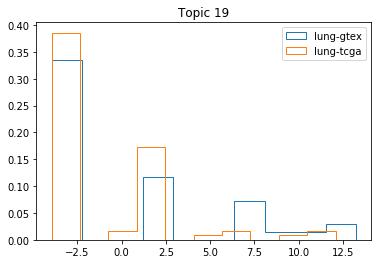

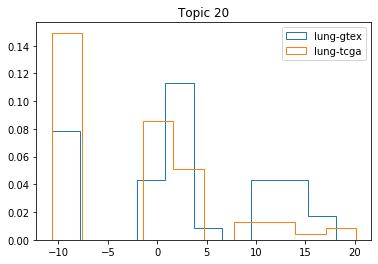

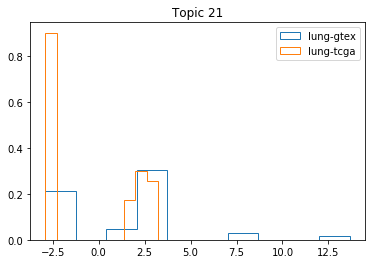

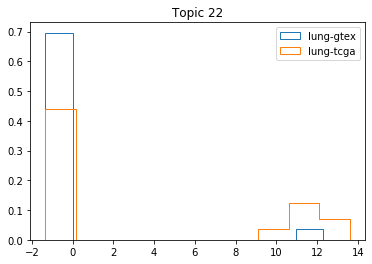

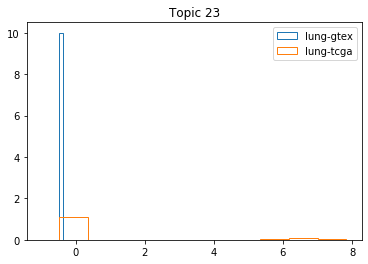

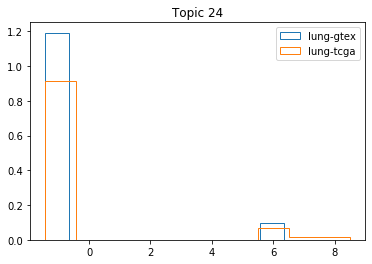

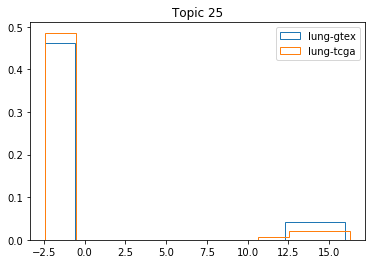

In [290]:
means = df_topics.groupby('tissue').agg(exprs).agg({x: 'avg' for x in ["avg(%s)"%t for t in topic_cols]}).toPandas()[["avg(avg(%s))"%topic for topic in topic_cols]]
means.columns=topic_cols
sigmas = df_topics.groupby('tissue').agg({x: "std" for x in topic_cols}).agg({x: 'std' for x in ["stddev(%s)"%t for t in topic_cols]}).toPandas()[["stddev(stddev(%s))"%topic for topic in topic_cols]]
sigmas.columns=topic_cols
for topic in topic_cols:
    plt.figure()
    plt.title(topic)
    healthy=(df_topics.filter(col('second_tissue')==look_for[1]).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
    disease=(df_topics.filter(col('second_tissue')==look_for[2]).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
    plt.hist(healthy.values.T[0], density=True, histtype='step', label=look_for[1])
    plt.hist(disease.values.T[0], density=True, histtype='step', label=look_for[2])
    plt.legend()
    plt.show()

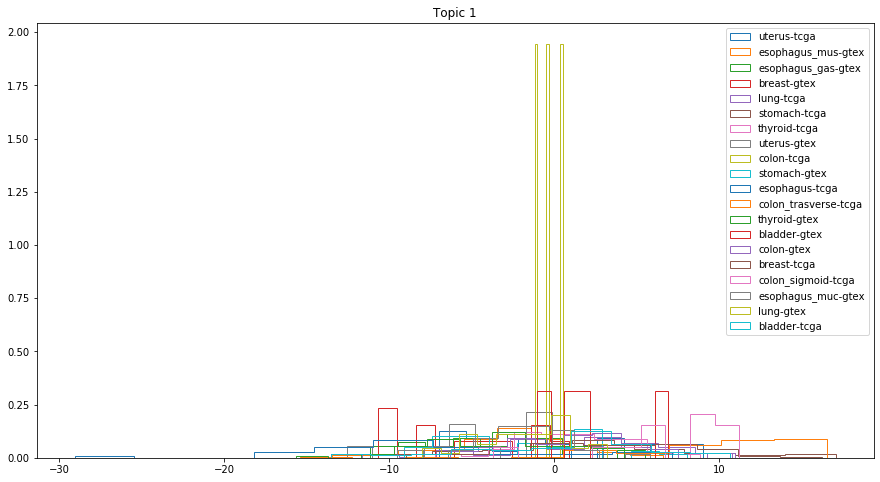

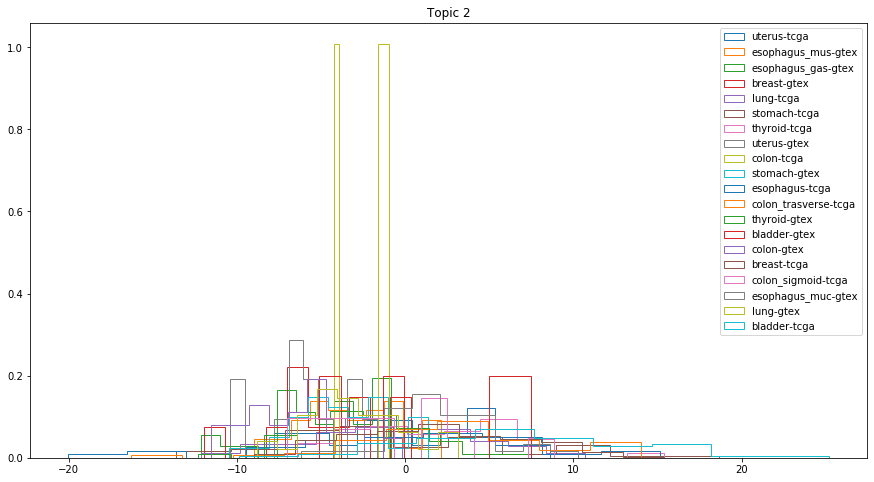

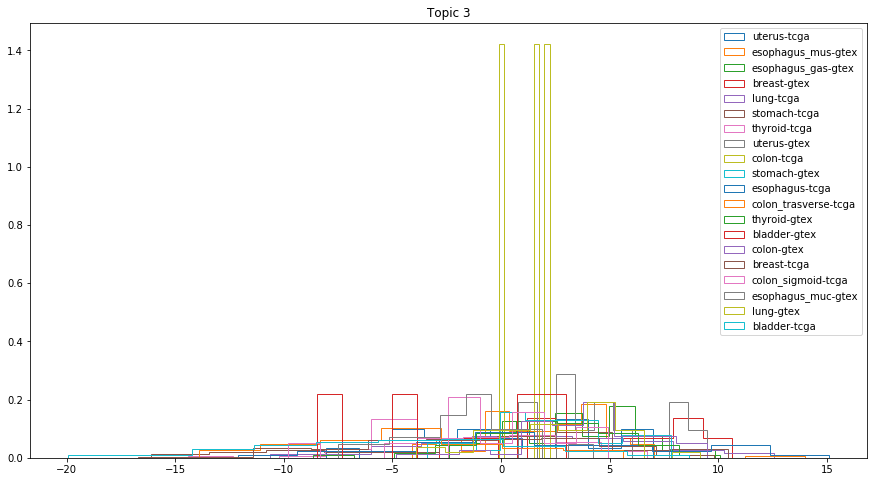

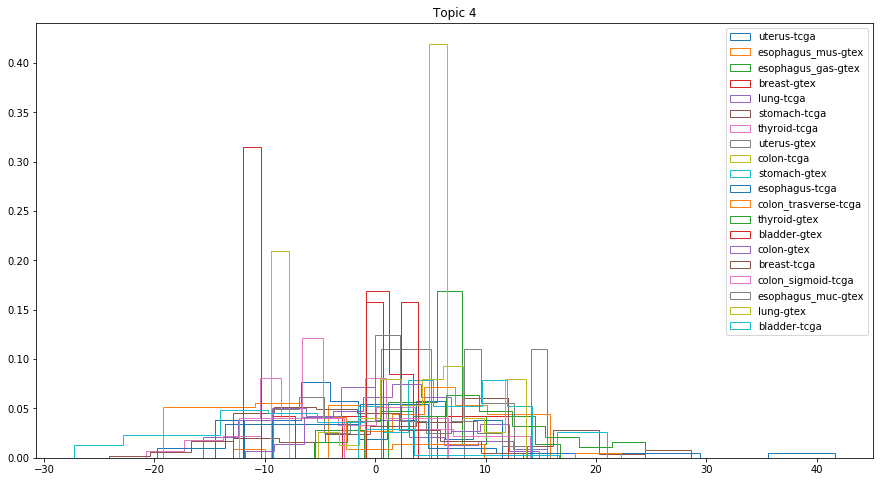

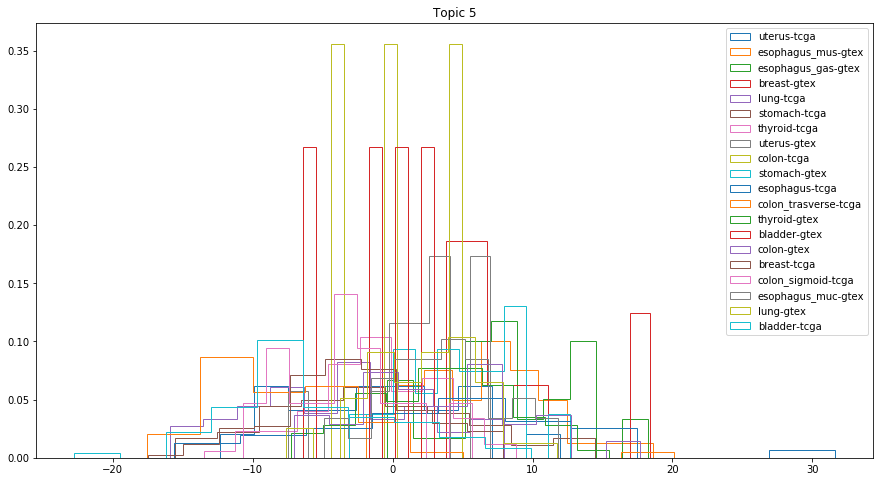

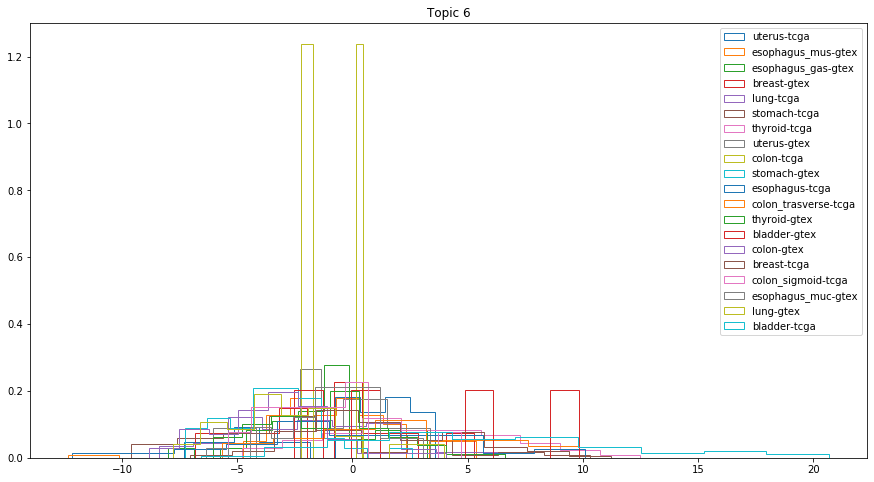

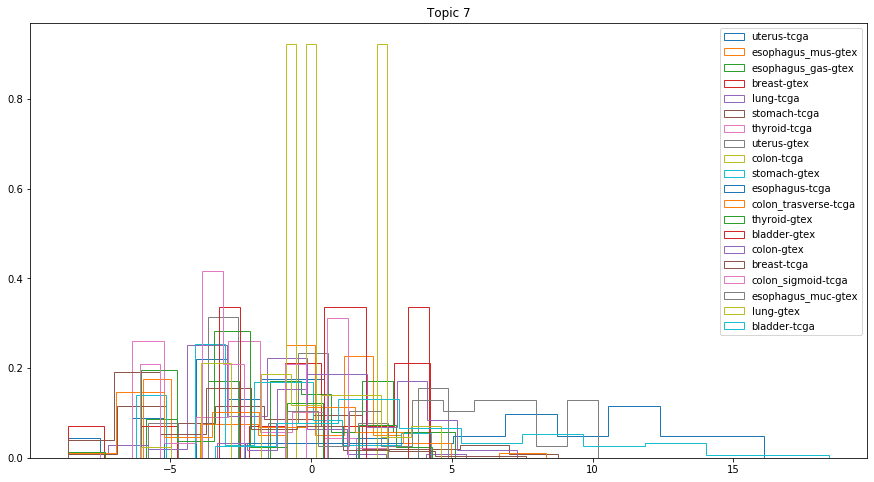

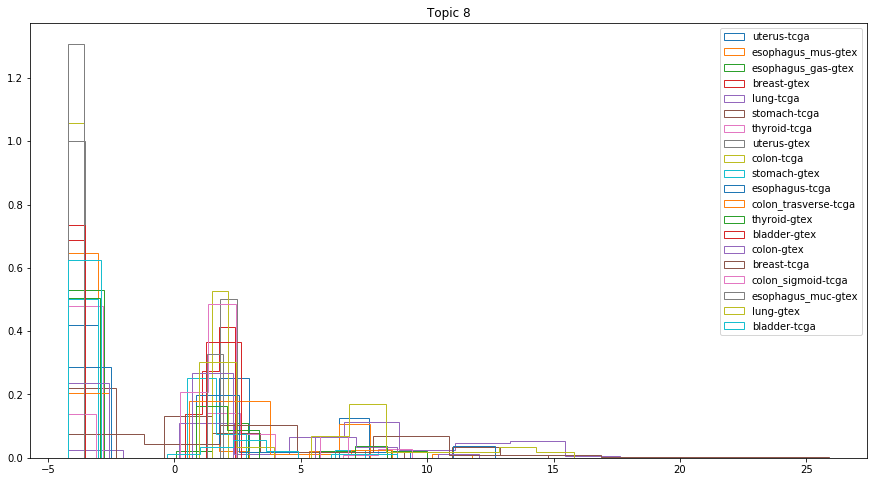

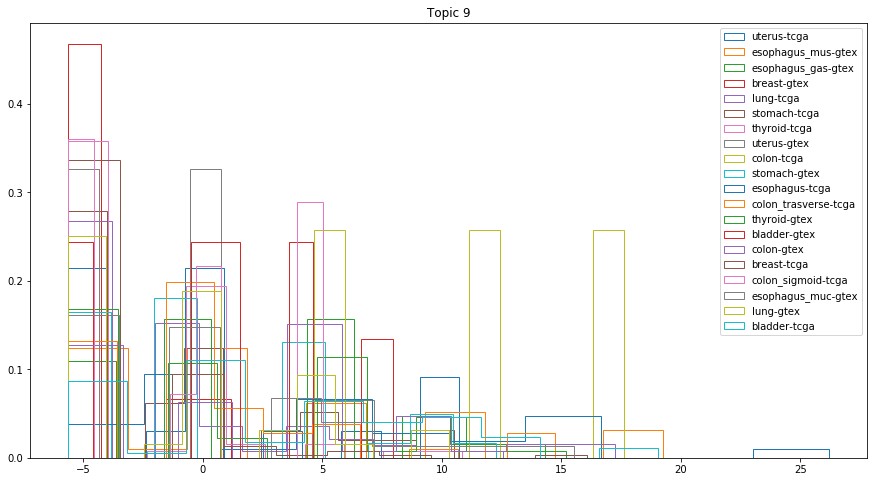

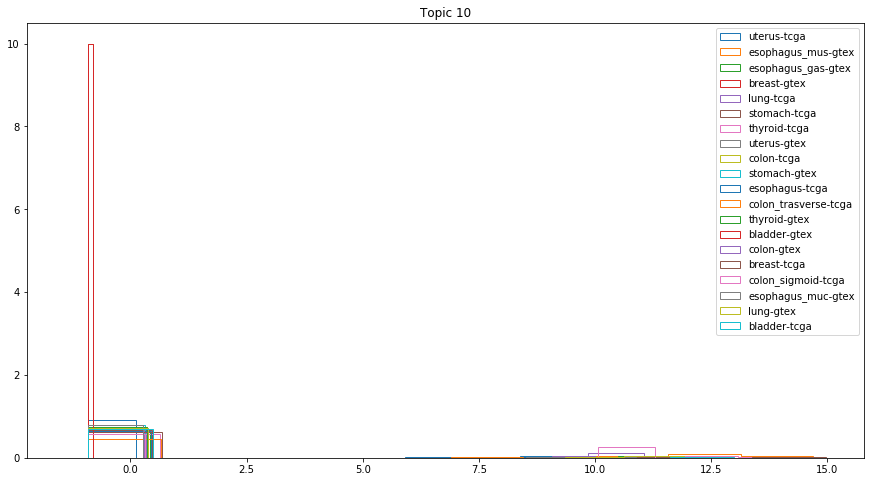

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd3dbe33950> (for post_execute):


KeyboardInterrupt: 

In [291]:
for topic in topic_cols:
    plt.figure(figsize=(15,8))
    plt.title(topic)
    for tissue in df_topics.select('second_tissue').distinct().toPandas().values.T[0]:
        tissue_spec=(df_topics.filter(col('second_tissue')==tissue).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
        plt.hist(tissue_spec.values.T[0], density=True, histtype='step', label=tissue)
    plt.legend()
    plt.show()

In [313]:
df_cmap = df_topics_grouped
df_cmap.divide(df_cmap.sum(axis=1), axis=0).sum(axis=1)

Topic 1     1.0
Topic 2     1.0
Topic 3     1.0
Topic 4     1.0
Topic 5     1.0
Topic 6     1.0
Topic 7     1.0
Topic 8     1.0
Topic 9     1.0
Topic 10    1.0
Topic 11    1.0
Topic 12    1.0
Topic 13    1.0
Topic 14    1.0
Topic 15    1.0
Topic 16    1.0
Topic 17    1.0
Topic 18    1.0
Topic 19    1.0
Topic 20    1.0
Topic 21    1.0
Topic 22    1.0
Topic 23    1.0
Topic 24    1.0
Topic 25    1.0
dtype: float64

In [293]:
df_topics_grouped = df_topics.groupby('second_tissue').agg({x: 'avg' for x in topic_cols}).toPandas().set_index('second_tissue')[["avg(%s)"%t for t in topic_cols]].transpose()
df_topics_grouped.index=topic_cols

In [320]:
df_cmap.mean(axis=1)-

Topic 1    -1.561251e-17
Topic 2    -3.469447e-18
Topic 3     3.816392e-17
Topic 4    -1.734723e-18
Topic 5    -8.673617e-19
Topic 6    -9.974660e-18
Topic 7    -1.084202e-19
Topic 8     5.421011e-20
Topic 9     1.084202e-19
Topic 10    1.355253e-20
Topic 11    0.000000e+00
Topic 12    3.252607e-19
Topic 13    5.421011e-20
Topic 14   -3.252607e-19
Topic 15   -1.084202e-19
Topic 16    0.000000e+00
Topic 17   -1.355253e-20
Topic 18   -5.421011e-20
Topic 19    5.421011e-20
Topic 20   -1.355253e-19
Topic 21    0.000000e+00
Topic 22   -1.355253e-20
Topic 23    0.000000e+00
Topic 24   -2.710505e-20
Topic 25    2.032879e-20
dtype: float64

<Figure size 432x288 with 0 Axes>

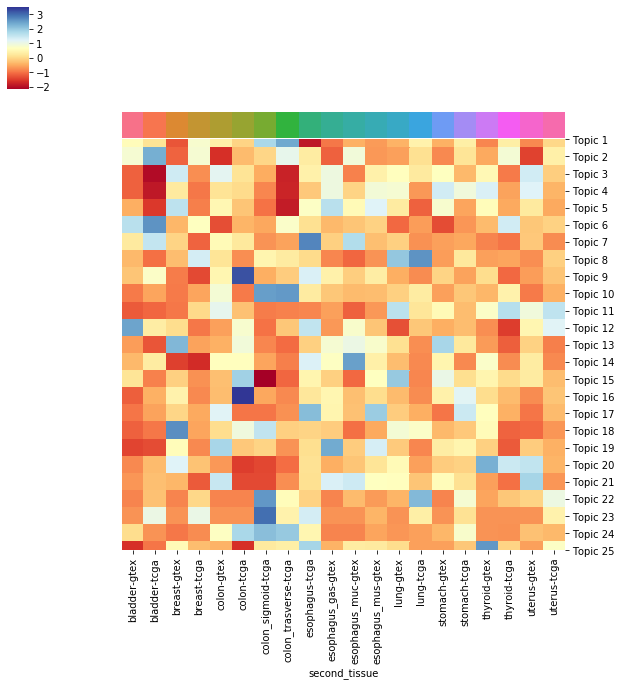

In [328]:
df_cmap = df_topics_grouped
df_cmap=df_cmap.subtract(df_cmap.mean(axis=1), axis=0).divide(df_cmap.std(axis=1), axis=0)
df_cmap.sort_index(axis=1, inplace=True)
#df_cmap.sort_values(by=[c for c in df_cmap.columns[::2]], inplace=True)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', cmap='RdYlBu', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


AttributeError: 'Rectangle' object has no property 'marker'

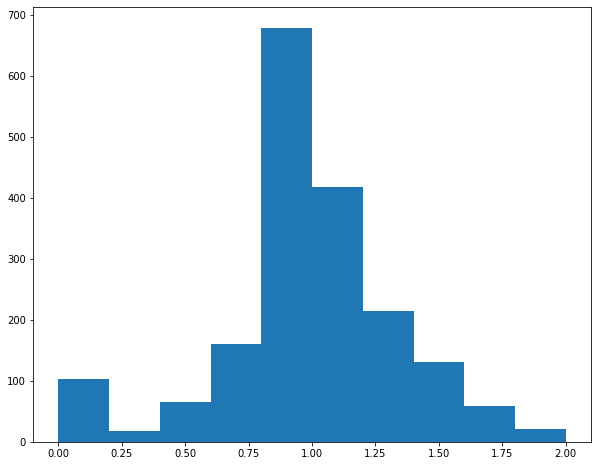

In [121]:
fig=plt.figure(figsize=(10,8))
#plt.plot((df_tissue).values[0], label=look_for[0], ls='--', ms=10)
plt.hist((df_tissue_healthy).values[0], label=look_for[1], marker='x', lw=0.5, ms=10)
plt.hist((df_tissue_disease).values[0], label=look_for[2], marker='x', lw=0.5, ms=10)
plt.xticks(ticks=np.arange(len(topic_cols)), labels=topic_cols, rotation=90)
#plt.yscale('log')
plt.legend(fontsize=20)
plt.show()

In [81]:
(df_tissue_healthy-df_tissue).values

array([[-1.54573159e-02, -1.91396894e-02,  2.33624794e-02,
         3.51529149e-03,  7.06638062e-03, -3.01455005e-03,
         7.50417231e-04, -4.65689332e-04,  1.82729614e-04,
        -2.05355654e-05, -3.98208907e-04,  5.24960296e-04,
         1.05590083e-03,  1.18734643e-04,  1.28504763e-04,
         1.68468643e-04,  2.43034498e-05,  8.93780276e-04,
         3.09631100e-04,  3.25361327e-04,  1.93212619e-04,
        -5.61370249e-05, -8.61719815e-05, -2.76223246e-05,
         4.57641189e-05]])

### all

In [ ]:
df_all = tf.convert_to_tensor(sql.sql("SELECT * FROM topic").toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float))

In [ ]:
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.math.reduce_mean(df_all, 0))
normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [ ]:
with tf.Session() as sess:
    result = sess.run([normed_df])

In [ ]:
fig=plt.figure(figsize=(30,15))
label = 'second_tissue'
for tissue in ['breast-gtex', 'breast-tcga', 'colon-gtex', 'colon-tcga','thyroid-gtex','thyroid-tcga']:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.8, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=18, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=44)
plt.xticks(np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), low_occ_topics, rotation=90, fontsize=24)
#plt.yscale('log')
plt.show()
fig.savefig("%s/lifeplot_normalised_level%d_hd.pdf"%(directory,l))

In [ ]:
fig=plt.figure(figsize=(30,15))
label='tissue'
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    fig=plt.figure(figsize=(30,15))
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.1, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
    plt.legend(fontsize=16, ncol=4)
    plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=24)
    plt.xticks(ticks=np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), labels=low_occ_topics, rotation=90, fontsize=24)
    plt.show()
    fig.savefig("%s/%s/lifeplot_normalised_%s_%s.pdf"%(directory,algorithm,label,tissue))

In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import get_tissue_style

In [ ]:
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = sql.sql("SELECT * FROM topic WHERE tissue='%s'"%tissue).toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.columns:
        plt.barh(df_visual.index.values,df_visual[t].values,left=width)
        width+=df_visual[t].values
    plt.show()
    fig.savefig("%s/%s/topicvisual_%s.png"%(directory,algorithm,tissue))

In [ ]:
tf.reset_default_graph()
sc.stop()